# Linear regression with Pytorch

## Import libraries

In [2]:
from torch import nn
from torch.nn import functional as F
import torch
from glob import glob
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import os
from matplotlib import pyplot as plt
import random
import numpy as np

IMG_SIZE = 256
BATCH_SIZE = 8
TEST_RATE = 0.2
root_path =  os.getcwd() 
EPOCHS = 40

print(root_path)


e:\VSCODE\Python\AI-experiments\Experiment1


## Generate Dataset

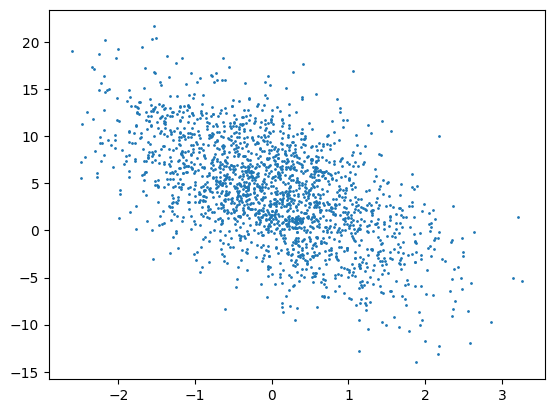

In [3]:
input_nums = 3
samples_num = 2000
true_w = [2, -3.4, 4.2]
true_b = 4.2
features = torch.randn(samples_num, input_nums, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_w[2] * features[:, 2] + true_b
labels += torch.tensor(np.random.normal(0, 0.001, size=labels.size()), dtype=torch.float32)

# show data in scatter plot
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

## import data

In [4]:
dataset = TensorDataset(features, labels)

train_dataset, test_dataset = train_test_split(dataset, test_size=TEST_RATE, random_state=42)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [5]:
# for x, y in train_dataloader:
#     print(x, y)
#     break

## define model

In [6]:
class LinearNet(nn.Module):
    def __init__(self, input_nums):
        super(LinearNet, self).__init__()
        self.linear1 = nn.Linear(input_nums, 8)
        self.linear2 = nn.Linear(8, 16)
        self.linear3 = nn.Linear(16, 32)
        self.dropout = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32, 16)
        self.linear5 = nn.Linear(16, 8)
        self.linear6 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        # x = self.dropout(x)
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        # x = self.dropout(x)
        x = F.relu(self.linear5(x))
        x = self.linear6(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.constant_(m.bias, 0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [7]:
def print_model_summary(model):
    print(model)
    print("Model Summary:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")
            total_params += param.numel()
    print(f"Total Trainable Parameters: {total_params}")

model = LinearNet(input_nums=3)
model.initialize_weights()
print_model_summary(model)

LinearNet(
  (linear1): Linear(in_features=3, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=8, bias=True)
  (linear6): Linear(in_features=8, out_features=1, bias=True)
)
Model Summary:
Layer: linear1.weight | Size: torch.Size([8, 3]) | Parameters: 24
Layer: linear1.bias | Size: torch.Size([8]) | Parameters: 8
Layer: linear2.weight | Size: torch.Size([16, 8]) | Parameters: 128
Layer: linear2.bias | Size: torch.Size([16]) | Parameters: 16
Layer: linear3.weight | Size: torch.Size([32, 16]) | Parameters: 512
Layer: linear3.bias | Size: torch.Size([32]) | Parameters: 32
Layer: linear4.weight | Size: torch.Size([16, 32]) | Parameters: 512
Layer: linear4.bias | Size: torch.Size([16]) | Parameters: 16
Layer: linear5.weight | Size: tor

## Training Model

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

model = LinearNet(input_nums=3)
model.initialize_weights()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer.zero_grad(set_to_none=True)
scaler = torch.cuda.amp.GradScaler()
for epoch in range(1, 20+1):
    model.train()
    train_loss = 0.0
    for i, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        
        with torch.cuda.amp.autocast():
            y_pred = model(x)
            loss = criterion(y_pred, y.unsqueeze(1))
        train_loss += loss.item()
        
        scaler.scale(loss).backward()

        if (epoch+1) % 2 == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

    train_loss /= len(train_dataloader)
    writer.add_scalar('training loss', train_loss, epoch)
    print(f"Epoch: {epoch} | Training Loss: {train_loss}")

    # model.eval()
    # val_loss = 0.0
    # with torch.no_grad():
    #     for i, (x, y) in enumerate(test_dataloader):
    #         x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
    #         with torch.cuda.amp.autocast():
    #             y_pred = model(x)
    #             loss = criterion(y_pred, y.unsqueeze(1))
    #         val_loss += loss.item()
    # val_loss /= len(test_dataloader)
    # writer.add_scalar('validation loss', val_loss, epoch)
    # print(f"Epoch: {epoch} | Validation Loss: {val_loss}")

writer.close()


Epoch: 1 | Training Loss: 36.82652848184109
Epoch: 2 | Training Loss: 5.7603640756011005
Epoch: 3 | Training Loss: 4.799985743910074
Epoch: 4 | Training Loss: 4.385141889862716
Epoch: 5 | Training Loss: 4.282417293936014
Epoch: 6 | Training Loss: 4.2329587202705445
Epoch: 7 | Training Loss: 4.173734002169222
Epoch: 8 | Training Loss: 4.07904675770551
Epoch: 9 | Training Loss: 3.999159877076745
Epoch: 10 | Training Loss: 3.9663743283320216
Epoch: 11 | Training Loss: 3.897806103955954
Epoch: 12 | Training Loss: 3.8678272441681476
Epoch: 13 | Training Loss: 3.804555117879063
Epoch: 14 | Training Loss: 3.7787726112338715
Epoch: 15 | Training Loss: 3.736458997991867
Epoch: 16 | Training Loss: 3.7157045459002256
Epoch: 17 | Training Loss: 3.6852973215002565
Epoch: 18 | Training Loss: 3.6707691244455054
Epoch: 19 | Training Loss: 3.6411341018066743
Epoch: 20 | Training Loss: 3.6275279633980246


In [7]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer.zero_grad(set_to_none=True)

for epoch in range(1, 20+1):
    model.train()
    train_loss = 0.0
    for i, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        y_pred = model(x)
        loss = criterion(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    writer.add_scalar('training loss', train_loss, epoch)
    print(f"Epoch: {epoch} | Training Loss: {train_loss}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataloader):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(x)
            loss = criterion(y_pred, y.unsqueeze(1))
            val_loss += loss.item()

    val_loss /= len(test_dataloader)
    writer.add_scalar('validation loss', val_loss, epoch)
    print(f"Epoch: {epoch} | Validation Loss: {val_loss}")

Epoch: 1 | Training Loss: 39.20405366957188
Epoch: 1 | Validation Loss: 11.227199635505677
Epoch: 2 | Training Loss: 41.9912069773674
Epoch: 2 | Validation Loss: 41.66271457672119
Epoch: 3 | Training Loss: 45.76654120922089
Epoch: 3 | Validation Loss: 39.21659828186035
Epoch: 4 | Training Loss: 38.67194215536117
Epoch: 4 | Validation Loss: 31.738989334106446
Epoch: 5 | Training Loss: 36.758115234375
Epoch: 5 | Validation Loss: 39.0716731262207
Epoch: 6 | Training Loss: 33.32806876659393
Epoch: 6 | Validation Loss: 31.869940052032472
Epoch: 7 | Training Loss: 35.40015192508697
Epoch: 7 | Validation Loss: 33.27219745635986
Epoch: 8 | Training Loss: 35.4015372300148
Epoch: 8 | Validation Loss: 32.139278173446655
Epoch: 9 | Training Loss: 33.11851829171181
Epoch: 9 | Validation Loss: 32.071956958770755
Epoch: 10 | Training Loss: 33.01806662023068


KeyboardInterrupt: 